```shell
ls -a

unzip ml-100k.zip

cd ml-100k

head -5 u.user

head -5 u.item

head -5 u.data
```

# 1. 탐색적 EDA
데이터셋 특징 : http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

## 1.1 사용자 데이터(u.user) EDA
독립변수
- user id : continuous
- age : continuous
- gender : Categorical
- occupation : Categorical
- zip code : Continuous

### 1.1.1 변수(범주형)의 각 수준을 확인

In [1]:
PATH="/home/paulkim/workspace/Spark/semi_project/data/"
user_data = sc.textFile("%s/ml-100k/u.user"%PATH)
user_data.first()

'1|24|M|technician|85711'

In [2]:
user_fields = user_data.map(lambda line: line.split('|'))
user_fields.first()

['1', '24', 'M', 'technician', '85711']

In [3]:
num_users = user_fields.map(lambda fields: fields[0]).count()
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count()
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()
num_zipcods = user_fields.map(lambda fields: fields[4]).distinct().count()
print("Users : %d, genders : %d, occupations : %d, Zip codes : %d"%(num_users, num_genders, num_occupations, num_zipcods))

Users : 943, genders : 2, occupations : 21, Zip codes : 795


### 1.1.2 Age변수(연속형)의 분포를 확인

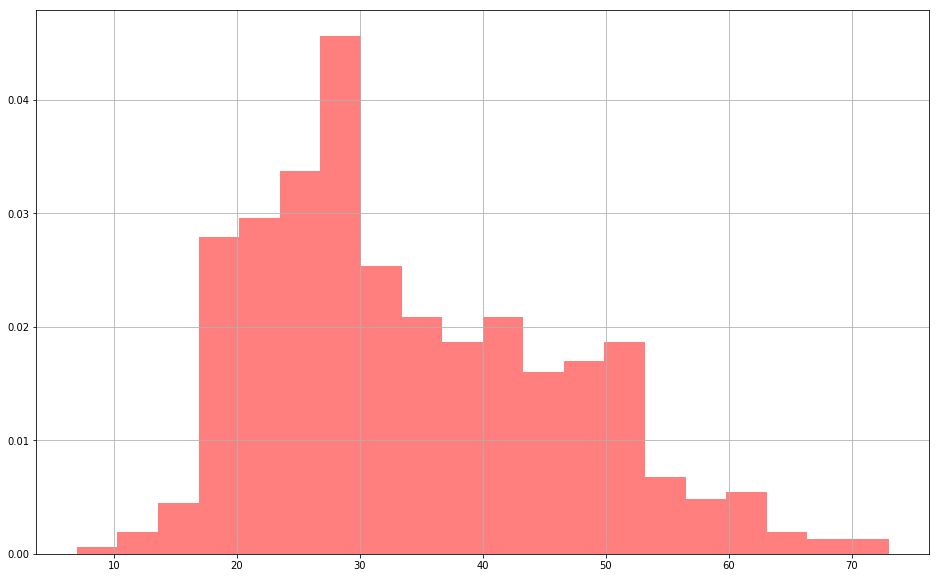

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

ages = user_fields.map(lambda fields: int(fields[1])).collect() # collect 액션
plt.hist(ages, bins=20, normed=1, color='r', alpha = 0.5)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(16, 10)

### 1.1.3 occupations변수의 수준별을 카운트

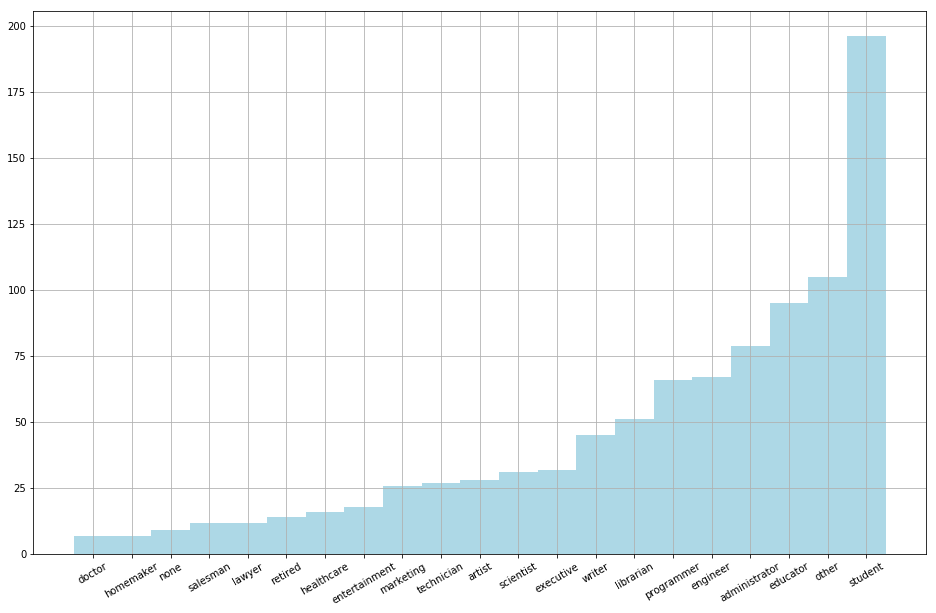

In [5]:
import numpy as np

# occupation의 각 수준별 mapreduce작업 수행
count_by_occupations = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y : x + y).collect()

x_axis1 = np.array([c[0] for c in count_by_occupations])
y_axis1 = np.array([c[1] for c in count_by_occupations])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
# ax.set_xticks(pos + (width / 2))
ax.set_xticks(pos)  
ax.set_xticklabels(x_axis)


plt.bar(pos, y_axis, width, color = 'lightblue')
plt.xticks(rotation=30)
plt.grid()

fig = plt.gcf()
fig.set_size_inches(16, 10)

In [6]:
count_by_occupations2 = user_fields.map(lambda fields: fields[3]).countByValue()
print("Map-reduce approach:")
print(dict(count_by_occupations))
print("CountByValue approach")
print(dict(count_by_occupations2))

Map-reduce approach:
{'other': 105, 'executive': 32, 'administrator': 79, 'student': 196, 'educator': 95, 'programmer': 66, 'homemaker': 7, 'artist': 28, 'engineer': 67, 'none': 9, 'retired': 14, 'doctor': 7, 'technician': 27, 'writer': 45, 'lawyer': 12, 'scientist': 31, 'entertainment': 18, 'librarian': 51, 'marketing': 26, 'healthcare': 16, 'salesman': 12}
CountByValue approach
{'technician': 27, 'other': 105, 'writer': 45, 'executive': 32, 'administrator': 79, 'student': 196, 'lawyer': 12, 'educator': 95, 'scientist': 31, 'entertainment': 18, 'programmer': 66, 'librarian': 51, 'homemaker': 7, 'artist': 28, 'engineer': 67, 'marketing': 26, 'none': 9, 'healthcare': 16, 'retired': 14, 'salesman': 12, 'doctor': 7}


## 1.2 영화 데이터(u.item) EDA
- movie id
- movie title
- release date
- video release date
- IMDb URL

하나의 영화는 복수개의 장르를 갖음(각각 바이너리형태)
- unknown
- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western

In [7]:
movie_data = sc.textFile('%s/ml-100k/u.item'%PATH)
print(movie_data.first())
num_movies = movie_data.count()
print("Movies : %d"%num_movies)

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies : 1682


### 1.2.1 영화의 나이(영화개봉 연도 - 기준년도)
- 데이터셋를 기준으로 당시는 1998년도임

In [8]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 # there is a 'bad' data point with a blank year, which we set to 1900 and will filter out later

movie_fields = movie_data.map(lambda lines: lines.split("|"))
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
# we filter out any 'bad' data points here
years_filtered = years.filter(lambda x: x != 1900)
# plot the movie ages histogram
movie_ages = years_filtered.map(lambda yr: 1998 - yr).countByValue()

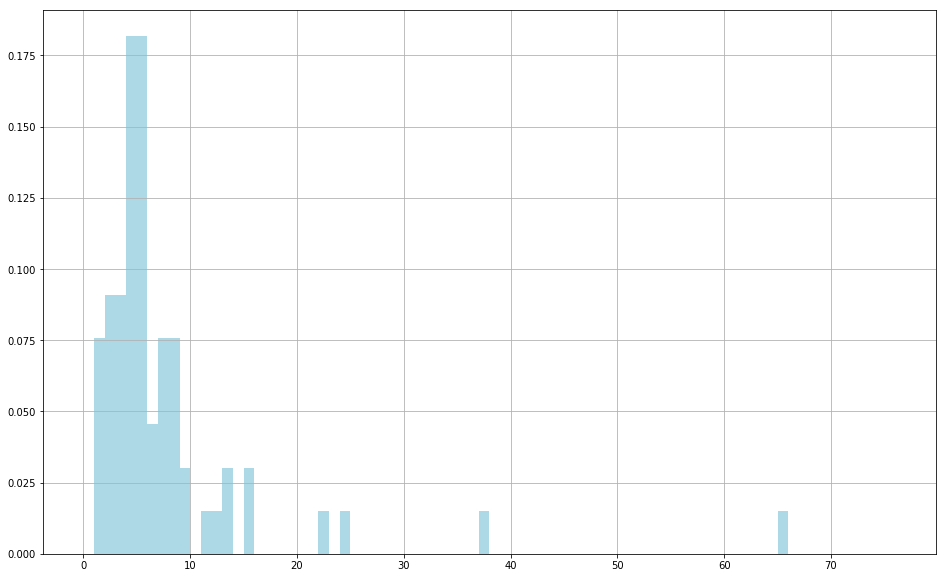

In [9]:
plt.hist(movie_ages.values(), bins=sorted(movie_ages.keys()), color='lightblue', normed=True)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(16,10)

1998년도를 기준으로 개봉된 영화들이 존재하는 것을 확인할 수 있음

## 1.3 평점데이터 탐색(u.data) EDA
변수특징
- user Id
- item Id
- rating
- timestamp(1/1/1970 UTC )

In [10]:
rating_data_raw = sc.textFile('%s/ml-100k/u.data'%PATH)
print(rating_data_raw.first())
num_ratings = rating_data_raw.count()
print("Ratings : %d"%num_ratings)

196	242	3	881250949
Ratings : 100000


### 1.3.1 영화평점의 기술통계량


In [11]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
rating_data.take(5)

[['196', '242', '3', '881250949'],
 ['186', '302', '3', '891717742'],
 ['22', '377', '1', '878887116'],
 ['244', '51', '2', '880606923'],
 ['166', '346', '1', '886397596']]

In [12]:
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y : max(x, y))
min_rating = ratings.reduce(lambda x, y : min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print("Min rating: %d" % min_rating)
print("Max rating: %d" % max_rating)
print("Average rating: %2.2f" % mean_rating)
print("Median rating: %d" % median_rating)
print("Average # of ratings per user: %2.2f" % ratings_per_user)
print("Average # of ratings per movie: %2.2f" % ratings_per_movie)

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.04
Average # of ratings per movie: 59.45


In [13]:
ratings.stats()

(count: 100000, mean: 3.5298600000000024, stdev: 1.12566797076, max: 5.0, min: 1.0)

### 1.3.2 영화평점의 분포 확인

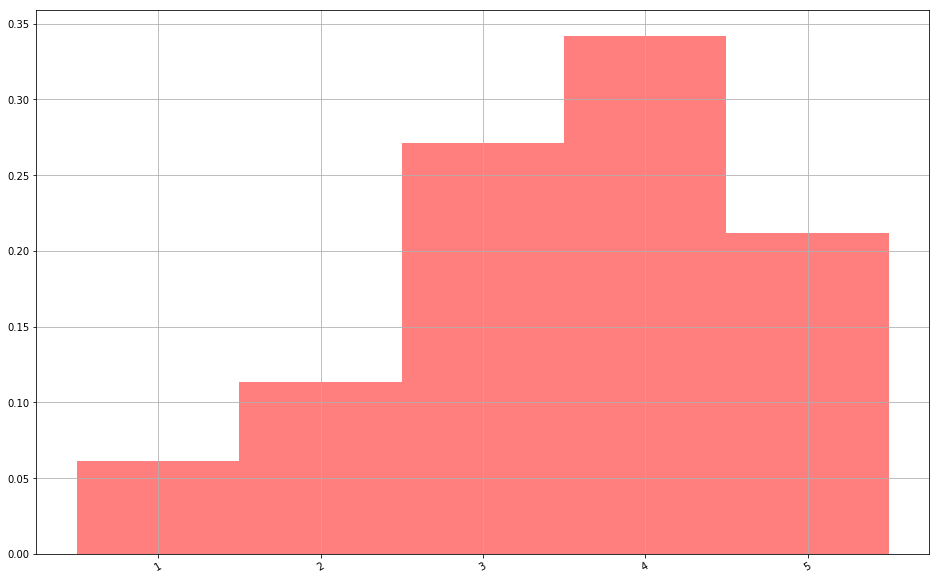

In [14]:
count_by_rating = sorted(ratings.countByValue().items())
x_axis = np.array([c[0] for c in count_by_rating])
y_axis = np.array([float(c[1]) for c in count_by_rating])
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='red', alpha=0.5)
plt.xticks(rotation = 30)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(16, 10)

### 1.3.3 사용자별 영화 평점 기록 횟수

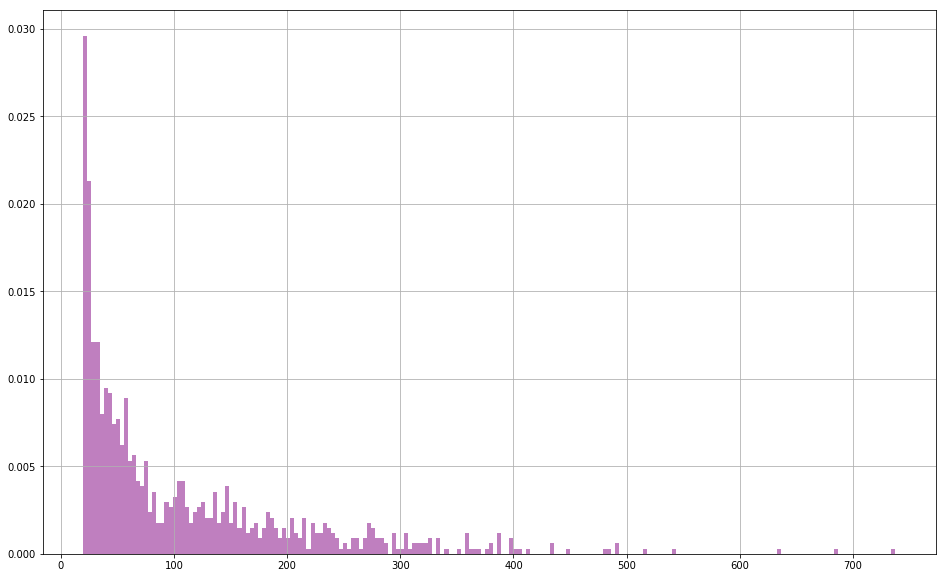

In [15]:
user_ratings_byuser = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).countByKey()
user_ratings_byuser_local = [v for k, v in user_ratings_byuser.items()]
plt.hist(user_ratings_byuser_local, bins=200, color='purple', alpha = 0.5, normed=True)
fig = plt.gcf()
plt.grid()
fig.set_size_inches(16, 10)

## 2. 데이터 전처리
### 2.1 결측치 처리

In [16]:
years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).filter(lambda yr : yr != 1900).collect()
years_pre_processed_arr = np.array(years_pre_processed)
years_pre_processed_arr

array([1995, 1995, 1995, ..., 1998, 1994, 1996])

In [17]:
mean_year = np.mean(years_pre_processed_arr[years_pre_processed_arr != 1900])
median_year = np.median(years_pre_processed_arr[years_pre_processed_arr != 1900])
idx_bad_data = np.where(years_pre_processed_arr == 1900)[0]

In [18]:
print("Mean year of release : %d"%mean_year)
print("Median year of release : %d"%median_year)
print("Index of '1900 after assigning median : %s"%np.where(years_pre_processed_arr == 1900)[0])

Mean year of release : 1989
Median year of release : 1995
Index of '1900 after assigning median : []


### 2.2 범주형 데이터를 원-핫 인코딩
- u.user의 occupation

In [19]:
all_occupations = user_fields.map(lambda fields: fields[3]).distinct().collect()
all_occupations.sort()

# 원-핫 벡터를 생성하기 위한 딕셔너리를 생성
idx = 0
all_occupations_dict = {}
for i in all_occupations:
    all_occupations_dict[i] = idx
    idx += 1
    
print("Encoding of 'doctor' : %d"%all_occupations_dict['doctor'])
print("Encoding of 'programmer' : %d"%all_occupations_dict['programmer'])
# type(all_occupations_dict)

Encoding of 'doctor' : 2
Encoding of 'programmer' : 14


In [20]:
K = len(all_occupations_dict)
binary_x = np.zeros(K) # 
k_programmer = all_occupations_dict['programmer'] # 인덱싱으로 value값을 뜯어옴
binary_x[k_programmer] = 1
print("Binary feature vector : %s"%binary_x)
print("Length of binary vector : %s"%K)

Binary feature vector : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]
Length of binary vector : 21


### 2.3 파생변수(매개변수) 생성
날짜형식의 변수를 범주형으로 변경
- **rating_data** : user id, movie id, ratings, timestamp(작성시간)
- (timestamp(1/1/1970 UTC )) -> hour

In [21]:
rating_data.first()

['196', '242', '3', '881250949']

In [22]:
def extract_datetime(ts):
    import datetime
    return datetime.datetime.fromtimestamp(ts)

timestamp = rating_data.map(lambda fields: int(fields[3]))
hour_of_day = timestamp.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

[0, 4, 16, 14, 14]

In [23]:
def assign_tod(hr):
    times_of_day = {
                'morning' : range(7, 12),
                'lunch' : range(12, 14),
                'afternoon' : range(14, 18),
                'evening' : range(18, 23),
                'night' : [23, 24, 0, 1, 2, 3, 4, 5, 6]
                }
    for k, v in times_of_day.items():
        if hr in v: 
            return k
        
time_of_day = hour_of_day.map(lambda hr: assign_tod(hr))
print(time_of_day.countByValue())

defaultdict(<class 'int'>, {'night': 46283, 'afternoon': 10363, 'evening': 6391, 'morning': 27864, 'lunch': 9099})


### 2.3 텍스트 데이터 변경
영화데이터의 movie title에서 개봉연도를 제외한 제목만 추출

In [24]:
def extract_title(raw):
    import re
    grps = re.search("\((\w+)\)", raw)
    if grps:
        return raw[:grps.start()].strip()
    else:
        return raw
    
raw_titles = movie_fields.map(lambda fields: fields[1])

In [25]:
movie_titles = raw_titles.map(lambda m: extract_title(m))
title_terms = movie_titles.map(lambda t: t.split(" "))
print(title_terms.take(5))

[['Toy', 'Story'], ['GoldenEye'], ['Four', 'Rooms'], ['Get', 'Shorty'], ['Copycat']]


In [26]:
"""
all_terms = title_terms.flatMap(lambda x: x).distinct().collect()

# 텍스트 데이터를 이용한 원핫벡터 생성
idx = 0
all_terms_dict = {}
for term in all_terms:
    all_terms_dict[term] = idx
    idx += 1
"""
all_terms_dict = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap()    

num_terms = len(all_terms_dict)
print("Total number of terms : %d"%num_terms)
print("Index of term 'Dead' : %d"%all_terms_dict['Dead'])
print("Index of term 'Rooms' : %d"%all_terms_dict['Rooms'])

Total number of terms : 2645
Index of term 'Dead' : 9
Index of term 'Rooms' : 2


### tip) spark sparse matrix
- 스파크에서는 사용하는 단어사전을 브로드캐스트로 설정하는 것을 권장함(defacto standard)

In [27]:
def create_vector(terms, term_dict):
    from scipy import sparse as sp
    x = sp.csc_matrix((1, num_terms))
    for t in terms:
        if t in term_dict:
            idx = term_dict[t]
            x[0, idx] = 1
    return x

all_terms_bcast = sc.broadcast(all_terms_dict)
print(len(all_terms_bcast.value))

2645


In [29]:
term_vectors = title_terms.map(lambda terms : create_vector(terms, all_terms_bcast.value))
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]